In [3]:
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime

In [4]:
#!pip install tensorflow

In [7]:
data=pd.read_csv('/Users/shwetatripathi//Time Series Forcasting /Datasets/MicrosoftStock.csv')
print(data.head())

    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [9]:
print(data.describe())

               index         open         high          low        close  \
count    1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean   390827.000000    51.026394    51.436007    50.630397    51.063081   
std       363.586303    14.859387    14.930144    14.774630    14.852117   
min    390198.000000    27.350000    27.600000    27.230000    27.370000   
25%    390512.500000    40.305000    40.637500    39.870000    40.310000   
50%    390827.000000    47.440000    47.810000    47.005000    47.520000   
75%    391141.500000    59.955000    60.435000    59.275000    59.730000   
max    391456.000000    95.140000    96.070000    93.720000    95.010000   

             volume  
count  1.259000e+03  
mean   3.386946e+07  
std    1.958979e+07  
min    7.425603e+06  
25%    2.254879e+07  
50%    2.938758e+07  
75%    3.842024e+07  
max    2.483542e+08  


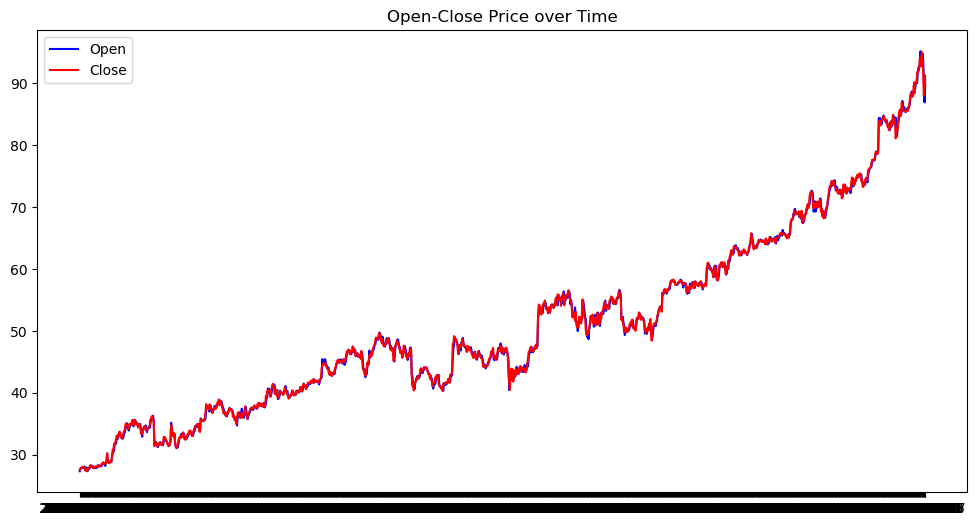

In [10]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['open'], label="Open",color="blue")
plt.plot(data['date'], data['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()
# plt.show()



Text(0.5, 1.0, 'Stock Volume over Time')

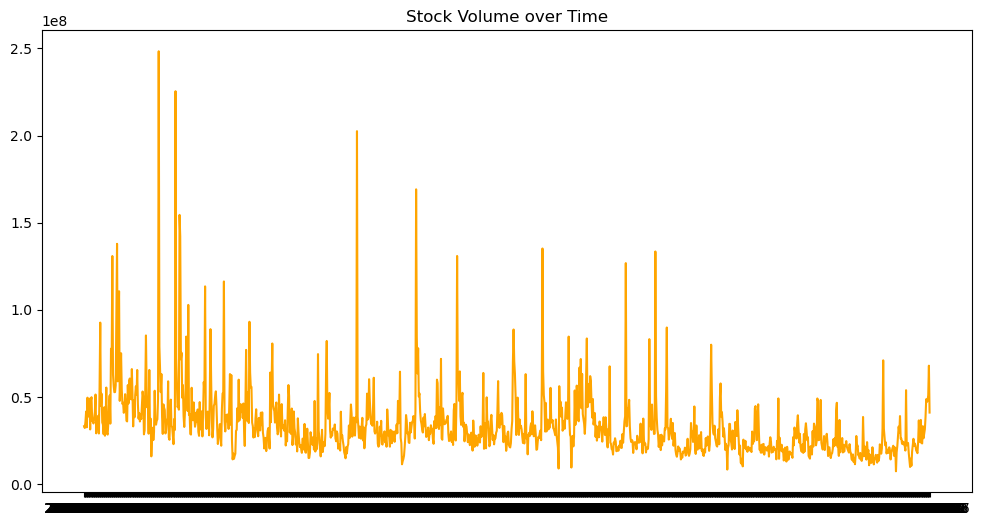

In [11]:
plt.figure(figsize=(12,6))
plt.plot(data['date'],data['volume'],label="Volume",color="orange")
plt.title("Stock Volume over Time")

In [12]:
numeric_data = data.select_dtypes(include=["int64","float64"]) # Drop non-numeric columns

Text(0.5, 1.0, 'Feature Correlation Heatmap')

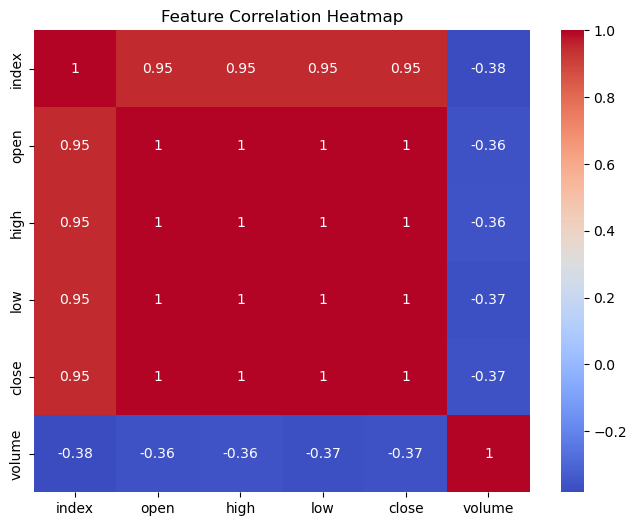

In [13]:
# Plot 3 - Check for correlation between features
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")

In [14]:
# Convert the Data into Date time then create a date filter
data['date'] = pd.to_datetime(data['date'])

In [15]:
prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) &
    (data['date'] < datetime(2018,1,1))
]

Text(0.5, 1.0, 'Price over time')

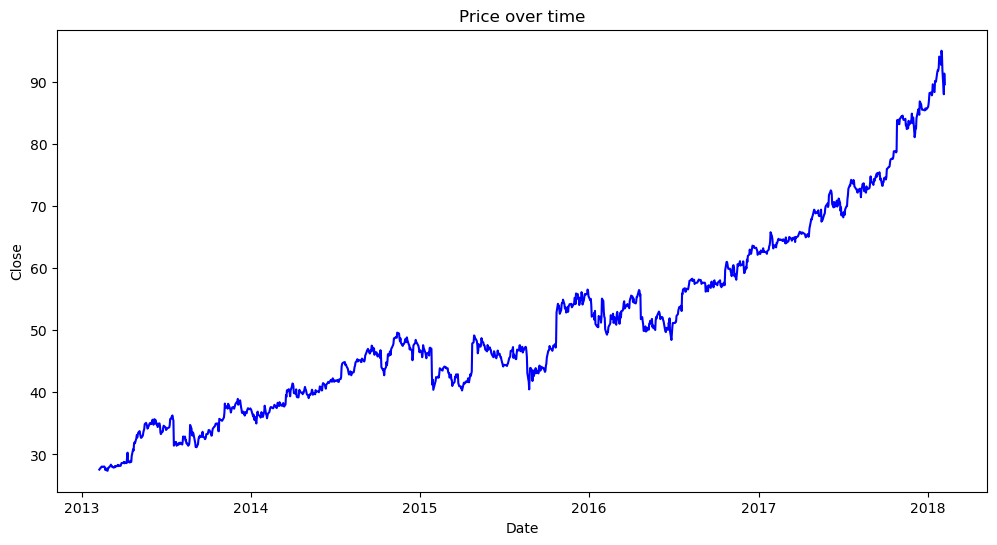

In [16]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'],color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")

In [17]:
# Prepare for the LSTM Model (Sequential)
stock_close = data.filter(["close"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))

In [19]:
# Preprocessing Stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
training_data = scaled_data[:training_data_len] 

In [20]:
X_train, y_train = [], []


# Create a sliding window for our stock (60 days)
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



In [21]:
# Build the Model
model = keras.models.Sequential()

# First Layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

# Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# 3rd Layer (Dense)
model.add(keras.layers.Dense(128, activation="relu"))

# 4th Layer (Dropout)
model.add(keras.layers.Dropout(0.5))

# Final Output Layer
model.add(keras.layers.Dense(1))

model.summary()
model.compile(optimizer="adam",
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError()])


training = model.fit(X_train, y_train, epochs=20, batch_size=32)

# Prep the test data
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]


for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2135 - root_mean_squared_error: 0.3127
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1361 - root_mean_squared_error: 0.1864
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1193 - root_mean_squared_error: 0.1638
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1122 - root_mean_squared_error: 0.1503
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1152 - root_mean_squared_error: 0.1576
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1075 - root_mean_squared_error: 0.1472
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1063 - root_mean_squared_error: 0.1444
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1050 - root_mean_squared_error: 0.1410
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1094 - root_mean_squared_error: 0.1474
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1066 - root_mean_squared_error: 0.1411

In [22]:
# Make a Prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


In [23]:
# Plotting data
train = data[:training_data_len]
test =  data[training_data_len:]

test = test.copy()

test['Predictions'] = predictions


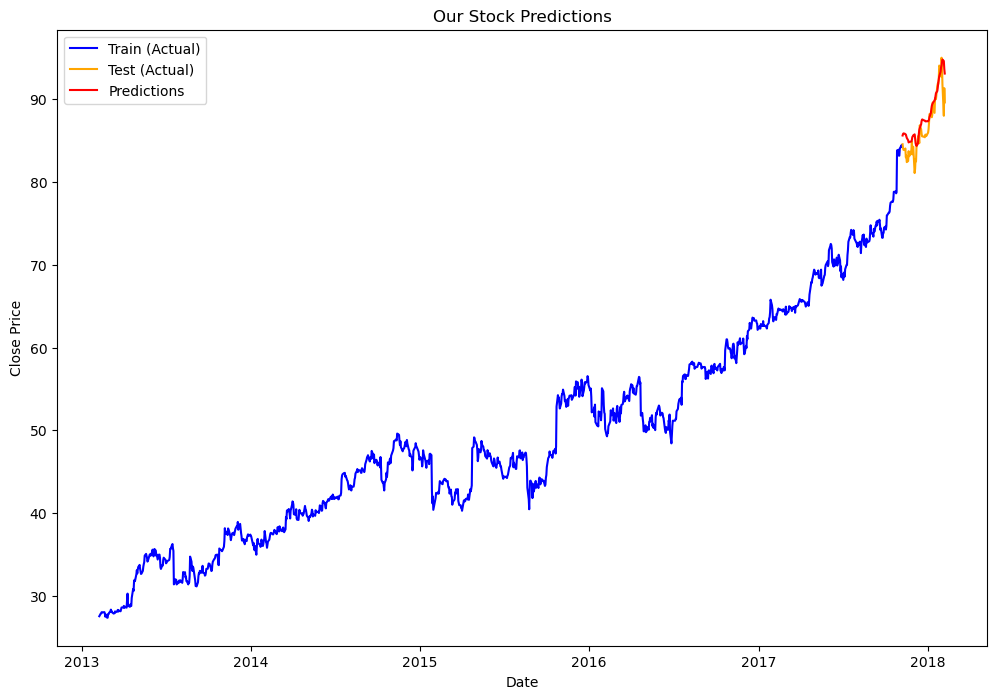

In [24]:
plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()